In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pymongo
from pymongo import MongoClient
import datetime
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
pip install pymongo

     |████████████████████████████████| 358kB 234kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
timeSeriesData = pd.DataFrame(columns=['symbol','date','cur_price','trade_quantity','updown_rate'])
timeSeriesCountData = pd.DataFrame(columns=['symbol','date','count'])

In [5]:

client = MongoClient('mongodb://127.0.0.1:27017/')
db = client['mph']
collection_price = db['crypto_prices']
collection_agg = db['token_aggs']

In [6]:
price_data = collection_price.find({'symbol':'LAT'})
agg_data = collection_agg.find({'symbol':'LAT'})
#data = collection.find()
print(agg_data)
index = 0

In [7]:
for price_detail in price_data:
    timeSeriesData.loc[index, 'symbol'] = price_detail['symbol']
    timeSeriesData.loc[index,'date']= price_detail['date']
    timeSeriesData.loc[index, 'cur_price'] = price_detail['cur_price']
    timeSeriesData.loc[index, 'trade_quantity'] = price_detail['trade_quantity']
    timeSeriesData.loc[index, 'updown_rate'] = price_detail['updown_rate']
    index+=1

index1 = 0

for agg_detail in agg_data:
    timeSeriesCountData.loc[index1, 'symbol'] = agg_detail['symbol']
    timeSeriesCountData.loc[index1,'date']= datetime.datetime.strptime(str(agg_detail['date']),'%Y%m%d')
    timeSeriesCountData.loc[index1, 'count'] = agg_detail['count']/18 # nomarlization
    index1+=1


timeSeriesData = timeSeriesData.sort_values(['date'])
timeSeriesCountData = timeSeriesCountData.sort_values(['date'])

In [8]:
print(timeSeriesData)
print(timeSeriesCountData)

    symbol                 date cur_price trade_quantity updown_rate
633    LAT  2018-03-02 00:00:00   0.30068              0       -1.79
617    LAT  2018-03-03 00:00:00   0.29182              0       -2.95
601    LAT  2018-03-04 00:00:00   0.30472              0        4.42
642    LAT  2018-03-05 00:00:00   0.31373              0        2.96
610    LAT  2018-03-06 00:00:00   0.27531              0      -12.25
..     ...                  ...       ...            ...         ...
4      LAT  2019-11-30 00:00:00   0.10797              0       21.49
2      LAT  2019-12-01 00:00:00   0.10565              0       -2.15
3      LAT  2019-12-02 00:00:00   0.11571              0        9.52
1      LAT  2019-12-03 00:00:00   0.11843              0        2.35
0      LAT  2019-12-04 00:00:00   0.11381              0        -3.9

[643 rows x 5 columns]
   symbol                 date      count
1     LAT  2017-10-25 00:00:00  0.0555556
0     LAT  2017-10-26 00:00:00  0.0555556
3     LAT  2017-10-28 

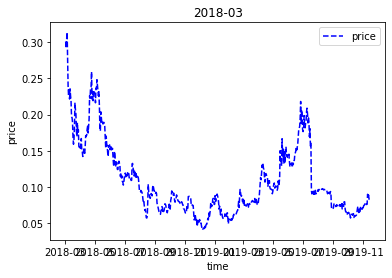

In [65]:
startDate1 = "2018-03-02"
endDate1 = "2019-11-15"

startDate = datetime.datetime.strptime(startDate1,"%Y-%m-%d")
endDate = datetime.datetime.strptime(endDate1,"%Y-%m-%d")

monthDate = startDate +pd.DateOffset(months=3)
###########################################################
# train을 위한 시계열 범위를 19년 4월 부터 6월 31일까지 1개 분기로 정함
###########################################################
timeSeriesData1 = timeSeriesData.loc[(timeSeriesData['date'] >= startDate) & (timeSeriesData['date'] <= endDate), :]
timeSeriesCountData1 = timeSeriesCountData.loc[(timeSeriesCountData['date'] >= startDate) & (timeSeriesCountData['date'] <= monthDate), :]

plt.plot(timeSeriesData1['date'].values, timeSeriesData1['cur_price'].values,'b--')
#plt.plot(timeSeriesCountData1['date'].values, timeSeriesCountData1['count'].values, 'ro')
plt.title(startDate.strftime('%Y-%m'))
plt.xlabel('time')
plt.ylabel('price')
plt.legend(['price','lift','downhill'])
plt.show()

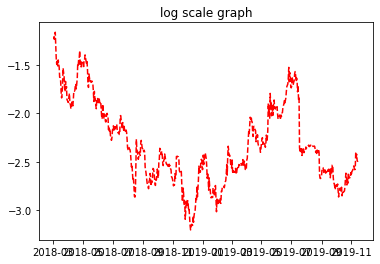

In [66]:
timeSeriesData1['log_price'] = np.log(np.array(timeSeriesData1['cur_price'],dtype=np.float32))

plt.plot(timeSeriesData1['date'].values, timeSeriesData1['log_price'].values, 'r--')
plt.title('log scale graph')
plt.show()

<Figure size 432x288 with 0 Axes>

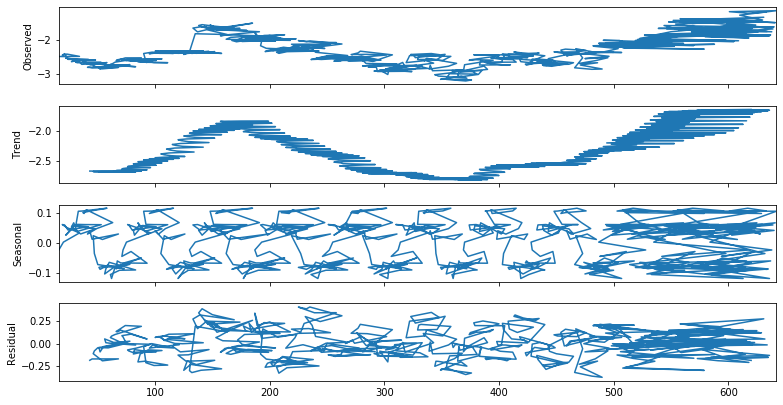

In [67]:
decompostion = seasonal_decompose(timeSeriesData1.log_price,freq=60)
fig = plt.figure()
fig = decompostion.plot()
fig.set_size_inches(12,6)

In [68]:
# 0 과 2 사이에서  p, d, q를 선언  
p = d= q = range(0,2)

In [69]:
# 가능한 모든 다른 조합을 만들어 냄 
pdq = list(itertools.product(p,d,q))

In [70]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [71]:
seasonal_pdq = [(x[0],x[1],x[2],60) for x in list(itertools.product(p,d,q))]

In [72]:
seasonal_pdq

[(0, 0, 0, 60),
 (0, 0, 1, 60),
 (0, 1, 0, 60),
 (0, 1, 1, 60),
 (1, 0, 0, 60),
 (1, 0, 1, 60),
 (1, 1, 0, 60),
 (1, 1, 1, 60)]

In [73]:
warnings.filterwarnings("ignore")

In [74]:
for param in pdq :
    for param_seasonal in seasonal_pdq :
        try :
            mod = sm.tsa.statespace.SARIMAX(timeSeriesData1.log_price,
                                           order = param ,
                                           trend = 't',
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA {} x {} - AIC:{}'.format(param,param_seasonal,results.aic))
        except : 
            print('exception')
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 60) - AIC:1873.566338440547
ARIMA (0, 0, 0) x (0, 0, 1, 60) - AIC:1204.9062561176938
ARIMA (0, 0, 0) x (0, 1, 0, 60) - AIC:627.2284006572169
ARIMA (0, 0, 0) x (0, 1, 1, 60) - AIC:583.2749003821541
ARIMA (0, 0, 0) x (1, 0, 0, 60) - AIC:629.8655648493768
ARIMA (0, 0, 0) x (1, 0, 1, 60) - AIC:630.8701827730092
ARIMA (0, 0, 0) x (1, 1, 0, 60) - AIC:586.3194896871337
ARIMA (0, 0, 0) x (1, 1, 1, 60) - AIC:590.5151115821261
ARIMA (0, 0, 1) x (0, 0, 0, 60) - AIC:1070.3027683766365
ARIMA (0, 0, 1) x (0, 0, 1, 60) - AIC:554.9102770822831
ARIMA (0, 0, 1) x (0, 1, 0, 60) - AIC:44.5752613916405
ARIMA (0, 0, 1) x (0, 1, 1, 60) - AIC:56.5117490288035
ARIMA (0, 0, 1) x (1, 0, 0, 60) - AIC:233.58423754291098
ARIMA (0, 0, 1) x (1, 0, 1, 60) - AIC:48.800618218056755
ARIMA (0, 0, 1) x (1, 1, 0, 60) - AIC:63.01273183343205
ARIMA (0, 0, 1) x (1, 1, 1, 60) - AIC:36.4283958548096
ARIMA (0, 1, 0) x (0, 0, 0, 60) - AIC:-1583.9949837617837
ARIMA (0, 1, 0) x (0, 0, 1, 60) - AIC:-1437.8

In [93]:
mod = sm.tsa.statespace.SARIMAX(timeSeriesData1.log_price,
                               order=(0,0,1),
                               seasonal_order=(1,1,1,60),
                               trend='t',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          log_price   No. Observations:                  624
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 60)   Log Likelihood                 -13.214
Date:                            Thu, 19 Dec 2019   AIC                             36.428
Time:                                    20:49:59   BIC                             57.521
Sample:                                         0   HQIC                            44.704
                                            - 624                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -3.286e-05   5.09e-05     -0.645      0.519      -0.000    6.69e-05
ma.L1          0.8017      0.030   

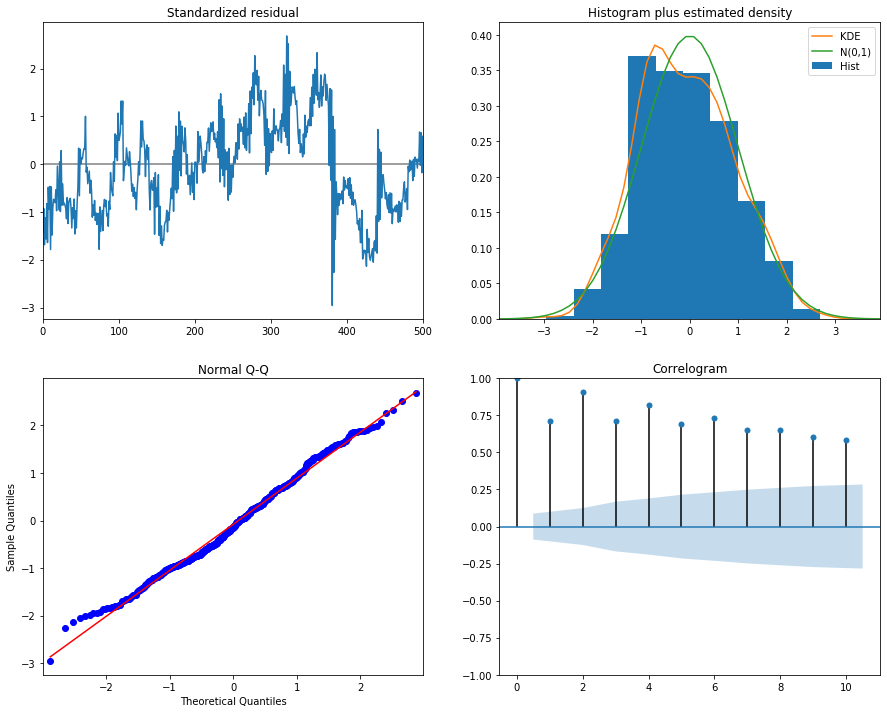

In [94]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

In [103]:
timeSeriesData1['forecast'] = results.predict(start=523, end=643,dynamic = True)

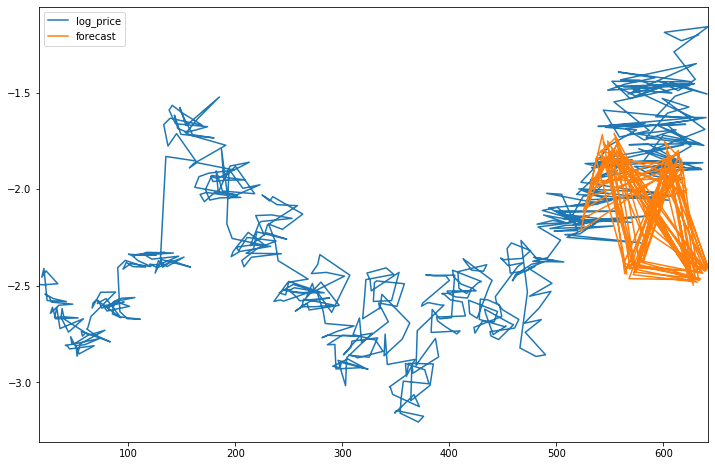

In [104]:
timeSeriesData1[['log_price','forecast']].plot(figsize=(12,8))